# Group 33 Project Report

Date: April 16, 2021

Group Members: Kyra Priestman, Vita Chan, Alex Piarkouski, Shinichi Ishikawa

### _Predicting Forest Fire Occurrence Based on Weather Conditions_

### Introduction

Fires are the most devastating natural threat to wooded areas of the Mediterranean(1). In Algeria, about 0.4 million hectares of forest were burned from 2006 to 2010(2). Additionally, several sources estimate the total annual cost of firefighting and safety devices in the Mediterranean region to be more than $1 billion USD(1). 

As the fire spreads, it becomes increasingly difficult for firefighters to control. Therefore, it’s essential to be able to predict the likelihood of a fire occurring for given weather conditions, so that authorities can react swiftly and prepare for potential forest fires during high-hazard conditions. 

**Scientific Question and Dataset Description**

_Using K-nearest neighbours classification, can forest fires be accurately predicted using past weather condition data?_

The dataset that we will be using is the “Algerian Forest Fires Dataset” from Faroudja Abid of the Center for Development of Advanced Technologies. It is accessible via the UCI Machine Learning Repository. The Algerian Forest Fires dataset investigates the Bejaia and Sidi Bel-abbes regions from June to September 2012, using 11 weather-related attributes to determine if a forest fire occurred or not (Class attribute). 

### Preliminary Exploratory Data Analysis

**Loading Libraries**

In [138]:
#Loading the necessary libraries
library(repr)
library(tidyverse)
library(tidymodels)

#Setting seed so we get reasonably random numbers
set.seed(1000)

#Helper function for visualization
options(repr.matrix.max.rows = 6)

**Reading, Cleaning, and Wrangling**

Columns 1, 123, 124 from the original data were metadata, and therefore skipped when reading the data. Empty rows were also skipped. Additionally, row 168 was formatted improperly (a delimiter is missing), therefore the row was skipped as well.

Data for the two regions was combined and column names remained constant. 

In [139]:
#Reading, cleaning, and wrangling the data
fire_data_1 <- (read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                       skip = 1, skip_empty_rows = TRUE, col_names = TRUE)[-c(123, 124, 168),]) %>%
                mutate(Classes = as_factor(Classes), 
                      Temperature = as.numeric(Temperature), 
                      RH = as.numeric(RH),
                      Ws = as.numeric(Ws),
                      Rain = as.numeric(Rain),
                      FWI = as.numeric(FWI),
                      ) 

#Renaming Classes to more descriptive title of "fire_occurrence"
names(fire_data_1)[names(fire_data_1) == 'Classes'] <- 'fire_occurrence'

fire_data_1

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,fire_occurrence
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


**Training and Test Sets**

We split the data into a training and test set. Only the training set will be used for creating the following tables and visualizations for our preliminary data analysis.

In [140]:
#Filtering first for our desired predictors and Class variable
filtered_fire <- fire_data_1 %>%
select(Temperature, RH, Ws, Rain, FWI, fire_occurrence)

#Splitting into training and test sets
fire_split <- initial_split(filtered_fire, prop = 0.75, strata = fire_occurrence)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)
fire_train
fire_test

Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,0.5,not fire
29,61,13,1.3,0.4,not fire
25,89,13,2.5,0.0,not fire
⋮,⋮,⋮,⋮,⋮,⋮
30,65,14,0.0,6.5,fire
28,87,15,4.4,0.0,not fire
24,54,18,0.1,0.7,not fire


Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
26,82,22,13.1,0.1,not fire
28,79,12,0.0,0.9,not fire
27,84,21,1.2,0.2,not fire
⋮,⋮,⋮,⋮,⋮,⋮
33,64,13,0.0,13.7,fire
27,87,29,0.5,0.2,not fire
24,64,15,0.2,0.5,not fire


**Summarizing Data in a Table - Number of Observations for "Fire" and "Not Fire"**

We counted the number of observations for each class to determine whether or not there may be a class imbalance. Based on the summary, we can see that there were 23 more observations for the "fire" class than the "not fire" class. This slight difference indicates that there is no need to balance our data. Also, considering that we are trying to find out which attributes are most likely to result in a fire occurring, our results should not be skewed by this slight difference in number of observations. With more "fire" observations, we can even observe the common attributes within this Class, as they all resulted in a fire occurring (e.g. increased rain was common throughout most of the "fire" observations). 

In [141]:
#Summarizing the training data in a table
observations_classes <- fire_train %>%  
                        select(fire_occurrence) %>%  
                        group_by(fire_occurrence) %>%  
                        summarize(n = n(),
                        percentage = n() / nrow(fire_train) * 100)
observations_classes

`summarise()` ungrouping output (override with `.groups` argument)



fire_occurrence,n,percentage
<fct>,<int>,<dbl>
not fire,80,43.71585
fire,103,56.28415


**Visualizations**

We created visualizations with the purpose of observing the types (including direction and strength) of relationships between our chosen predictors and fire occurence.

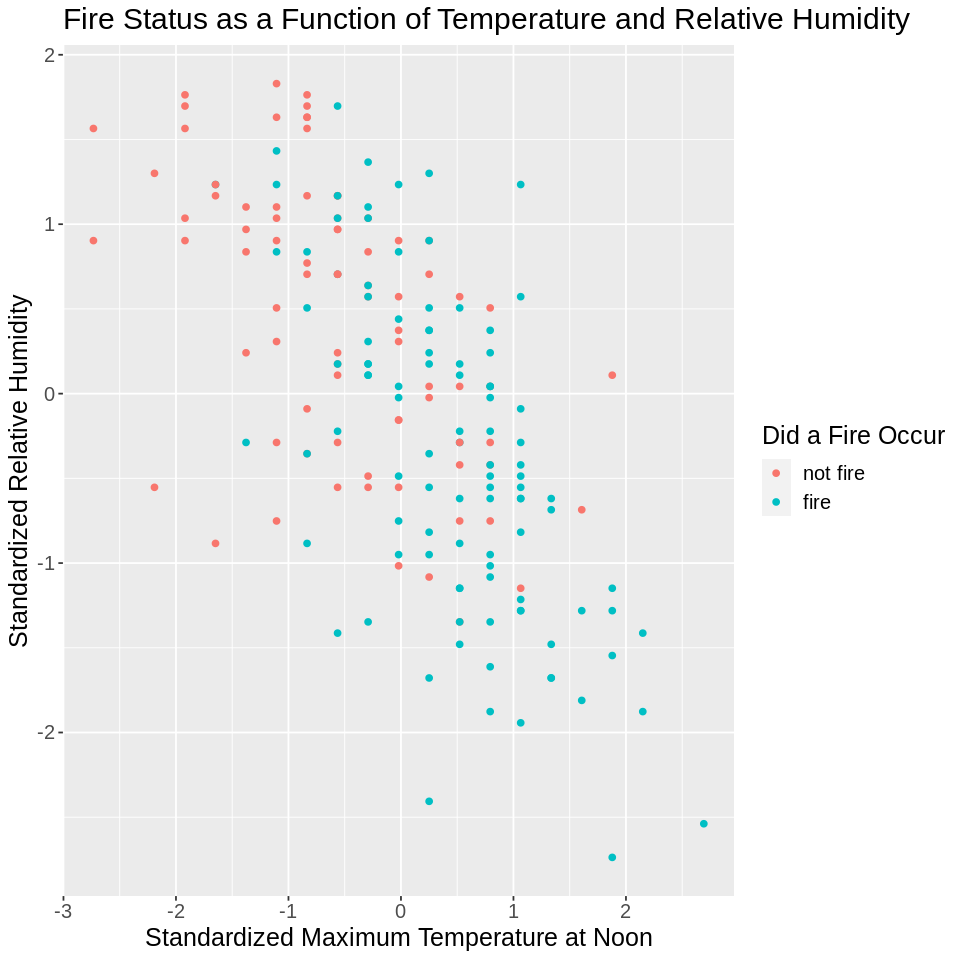

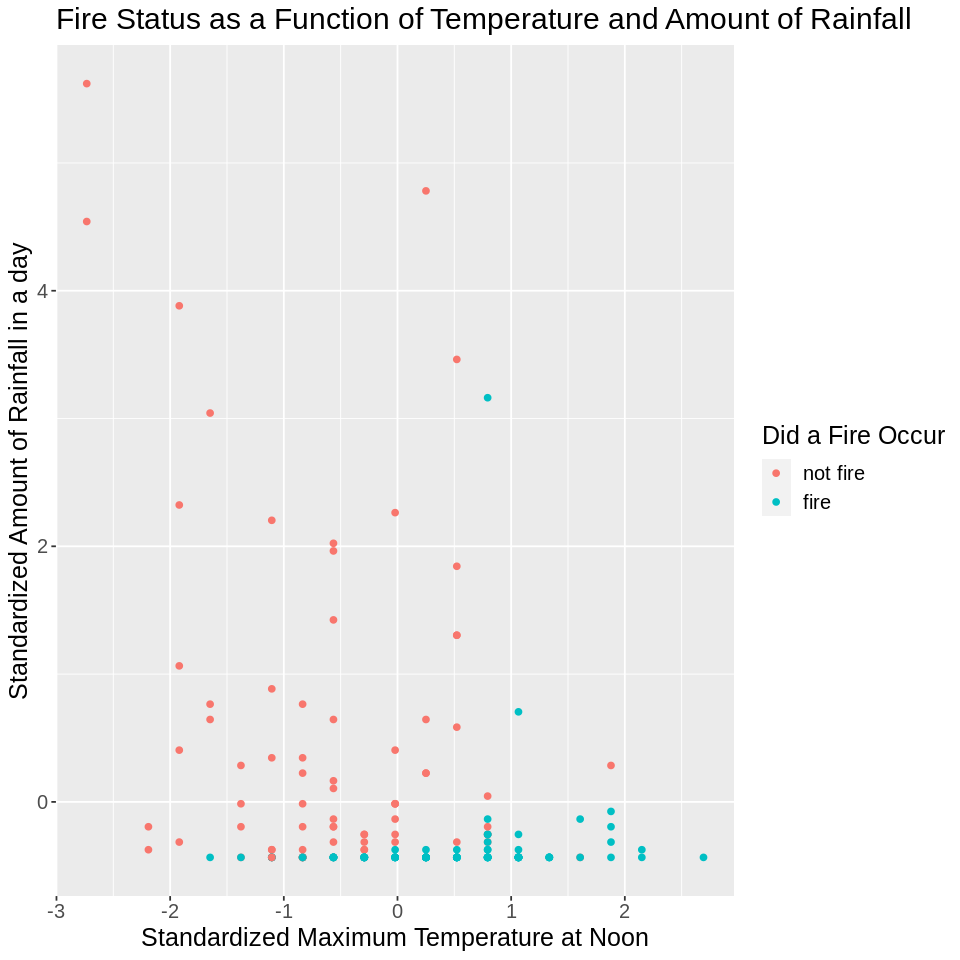

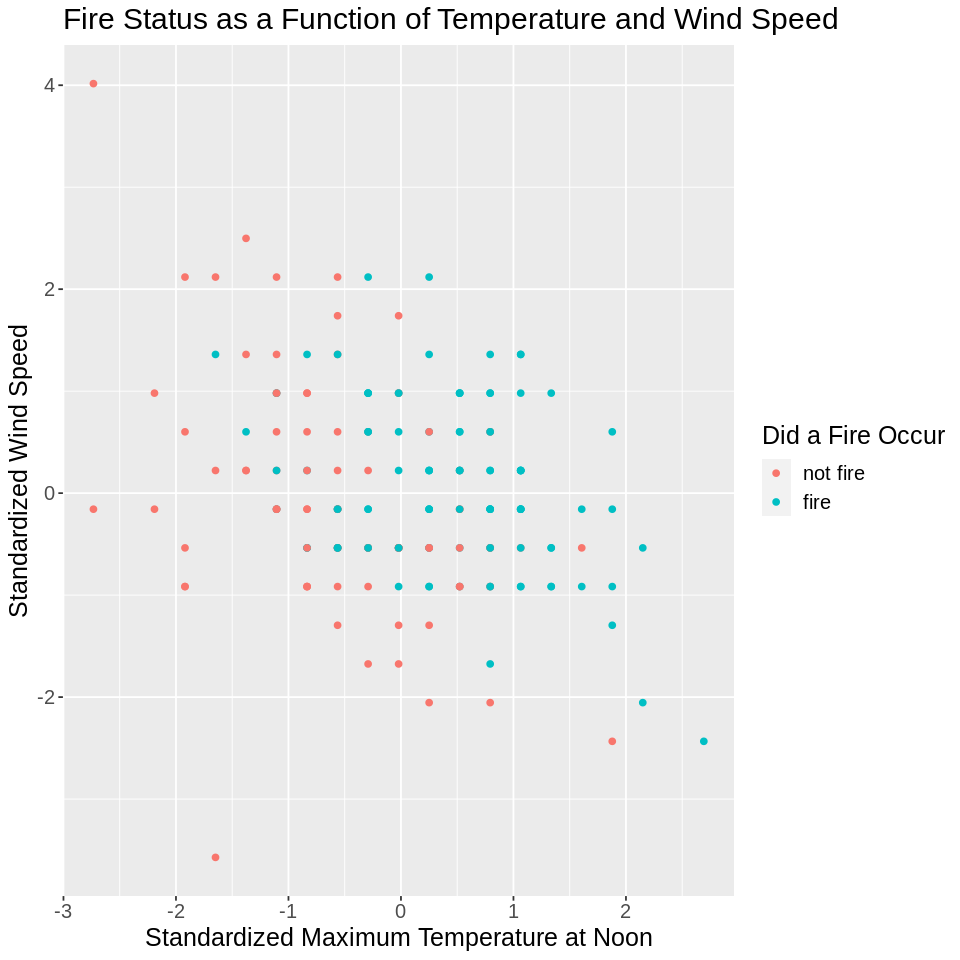

Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,0.5,not fire
29,61,13,1.3,0.4,not fire
25,89,13,2.5,0.0,not fire
⋮,⋮,⋮,⋮,⋮,⋮
30,65,14,0.0,6.5,fire
28,87,15,4.4,0.0,not fire
24,54,18,0.1,0.7,not fire


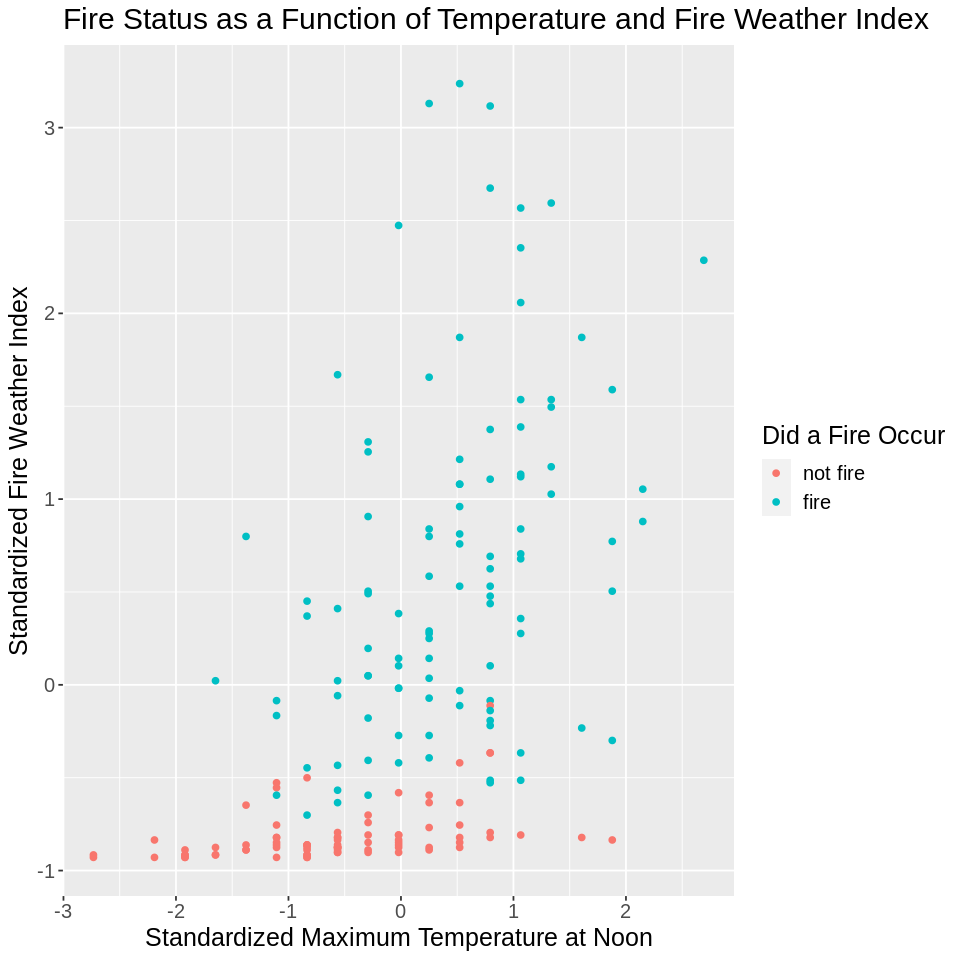

In [142]:
options(repr.plot.width=8, repr.plot.height=8)

#Standardizing data
standard_fire <- fire_train %>% 
                mutate(Temperature = scale(Temperature, center = TRUE), 
                RH = scale(RH, center = TRUE),
                Ws = scale(Ws, center = TRUE),
                Rain = scale(Rain, center = TRUE), 
                FWI = scale(FWI, center = TRUE))

#Temperature and relative humidity
temperature_humidity_plot <- standard_fire %>%
                            ggplot(aes(x = Temperature, y = RH, colour = fire_occurrence)) +
                            geom_point() + 
                            labs(x = "Standardized Maximum Temperature at Noon",
                                 y = "Standardized Relative Humidity",
                                colour = "Did a Fire Occur") +
                            ggtitle("Fire Status as a Function of Temperature and Relative Humidity") +
                                theme(text = element_text(size = 15))
temperature_humidity_plot

#Temperature and rain
temperature_rain_plot <- standard_fire %>%
                            ggplot(aes(x = Temperature, y = Rain, colour = fire_occurrence))+
                            geom_point() +
                            labs(x = "Standardized Maximum Temperature at Noon",
                                 y = "Standardized Amount of Rainfall in a day",
                                colour = "Did a Fire Occur") +
                            ggtitle("Fire Status as a Function of Temperature and Amount of Rainfall") +
                            theme(text = element_text(size = 15))
temperature_rain_plot

#Temperature and wind speed
temperature_wind_plot <- standard_fire %>%
                        ggplot(aes(x = Temperature, y = Ws, colour = fire_occurrence))+
                        geom_point() +
                        labs(x = "Standardized Maximum Temperature at Noon",
                             y = "Standardized Wind Speed",
                            colour = "Did a Fire Occur") +
                        ggtitle("Fire Status as a Function of Temperature and Wind Speed") +
                        theme(text = element_text(size = 15))
temperature_wind_plot

#Temperature and fire weather index
temperature_FWI_plot <- standard_fire %>%
                        ggplot(aes(x = Temperature, y = FWI, colour = fire_occurrence))+
                        geom_point() +
                        labs(x = "Standardized Maximum Temperature at Noon",
                             y = "Standardized Fire Weather Index",
                            colour = "Did a Fire Occur") +
                        ggtitle("Fire Status as a Function of Temperature and Fire Weather Index") +
                         theme(text = element_text(size = 15))
temperature_FWI_plot

fire_train

### Pre-processing the Data

Since we are performing a 5-fold cross-validation, we split the training data into 5 folds. In order to select the optimal K Value, we have created a k-nearest neighbour model with tune() as the parameter for the neighbors function. 

In [143]:
#Creating 5 folds
fire_vfold <- vfold_cv(fire_train, v = 5, strata = fire_occurrence)

#Creating fire_recipe using fire_train dataset.
fire_recipe <- recipe(fire_occurrence ~ ., data = fire_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

#Creating the k-nearest neighbors model with tune() function in order to find the optimal k value later on.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
              set_engine("kknn") %>%
              set_mode("classification")



### Finding the Optimal K Value

[1] 7

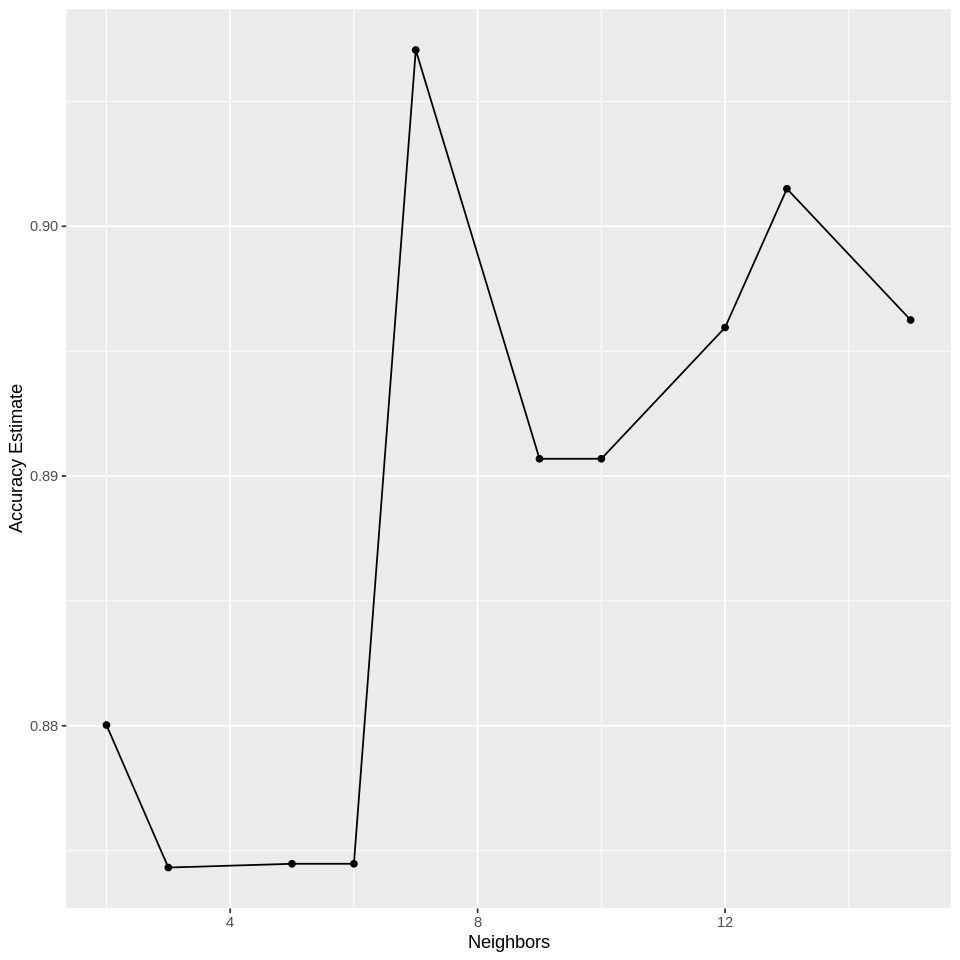

In [146]:
set.seed(1)

#Fitting the recipe and model to the dataset. Using filter() to select rows that show accuracies for 10 different k values.
accuracy_results <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = fire_vfold, grid = 10) %>%
  collect_metrics() %>%
  filter(.metric == "accuracy")

#Creating k_max variable that shows the rows with the max accuracy.
k_max <- accuracy_results %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)
k_max

#Creating a graph to visualize the accuracy of different k-values.
accuracy_vs_k <- ggplot(accuracy_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k


### Testing the Accuracy of the Model

In [145]:
# Recreating the model with the optimal k value that has been found previously.
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Retraining the data with the new model and fire_train dataset.
fire_fit <- workflow() %>%
              add_recipe(fire_recipe) %>%
              add_model(knn_spec_tuned) %>%
              fit(data = fire_train)

#Predicting the fire_accurrence based on the predictors using predict(). The predicted values are binded and named as .pred_class.
fire_test_predictions <- predict(fire_fit, fire_test) %>%
                          bind_cols(fire_test)
fire_test_predictions

fire_test_accuracy <- fire_test_predictions %>%
                        metrics(truth = fire_occurrence, estimate = .pred_class)
fire_test_accuracy

.pred_class,Temperature,RH,Ws,Rain,FWI,fire_occurrence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,26,82,22,13.1,0.1,not fire
not fire,28,79,12,0.0,0.9,not fire
not fire,27,84,21,1.2,0.2,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fire,33,64,13,0.0,13.7,fire
not fire,27,87,29,0.5,0.2,not fire
not fire,24,64,15,0.2,0.5,not fire


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8833333
kap,binary,0.7613636


### Methods

We will use the K-nearest neighbors classification algorithm for our model in predicting forest fires. Based on our preliminary exploratory data analysis, we have identified the following variables as being related to the fire_occurrence column which indicates whether or not there is a fire: 
* Temperature (max temperature at noon in Celsius degrees)
* RH (relative humidity in %)
* Ws (wind speed in km/h)
* Rain (total precipitation per day in mm)
* FWI (Fire Weather Index rating of fire intensity from 0 to 31.1)	

We will use the training set to conduct a 5-fold cross-validation to help us find the best K-value for our classification algorithm. Using the identified K-value we will further training our algorithm and use the testin set to determine its accuracy. 

We will use a line plot to see which K-value has the highest average accuracy based on our 5-fold cross-validation. Additionally, we may use scatter plots to help us visualize a new point and its K-nearest values. Since we can only compare the new point against two variables while using a scatter plot, this step will mainly be used as a loose check for our classification algorithm. 

### Expected Outcomes and Significance

We expect to find: 
* A positive correlation between fire occurrence and temperature.
* A negative correlation between fire occurrence and: 
    * relative humidity
    * rain precipitation
*A very weak correlation (positive) between fire occurrence and wind speed 

What impact could such findings have?

* Significant in forest fire prevention by predicting fires before they start
    * This would allow areas to adequately prepare in time for a fire (e.g. evacuation, alerting appropriate rescue services)
    * Regions that lack data and/or technology to predict fires would especially benefit
    * Authorities can educate the population to avoid all fire triggers & decrease overall fire occurrences
    
What future questions could this lead to?

* With increasing global temperatures, what is the predicted percentage increase in forest fires in the next decade? 
* Will current forest fire fighting methods (e.g. chemical retardants) become ineffective as the intensity and scale of fires worsens due to climate change? 

### References

(1) Alexandrian, D., Esnault, F., & Calabri, G. (1998, October 30). Public policies affecting forest fires. _Forest Fires in the Mediterranean Area_. http://www.fao.org/3/x1880e/x1880e07.htm

(2) Meddour-Sahar, O. (2015). Wildfires in Algeria: Problems and challenges. _IForest - Biogeosciences and Forestry_, 8(6), 818–826. https://doi.org/10.3832/ifor1279-007